# TMY data and diffuse irradiance models

This tutorial explores using TMY data as inputs to different plane of array diffuse irradiance models.

This tutorial has been tested against the following package versions:
* pvlib 0.2.0
* Python 2.7.10
* IPython 3.2
* pandas 0.16.2

It should work with other Python and Pandas versions. It requires pvlib > 0.2.0 and IPython > 3.0.

Authors:
* Rob Andrews (@Calama-Consulting), Heliolytics, June 2014
* Will Holmgren (@wholmgren), University of Arizona, July 2015

## Setup

See the ``tmy_to_power`` tutorial for more detailed explanations for the initial setup

In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# finally, we import the pvlib library
import pvlib

In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to a data file
datapath = os.path.join(pvlib_abspath, 'data', '703165TY.csv')

# read tmy data with year values coerced to a single year
tmy_data, meta = pvlib.tmy.readtmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
tmy_data = tmy_data.shift(freq='-30Min')

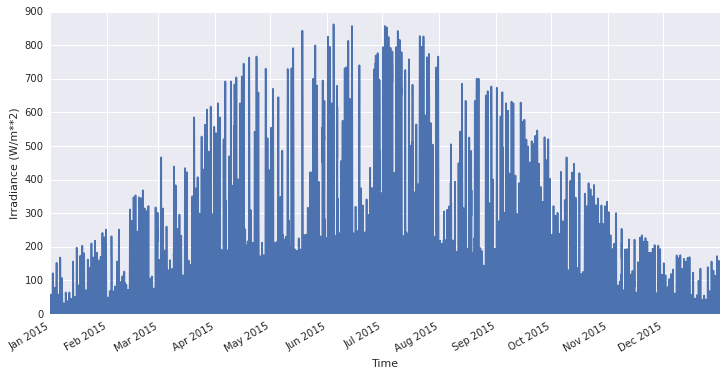

In [3]:
tmy_data.GHI.plot()
plt.ylabel('Irradiance (W/m**2)')

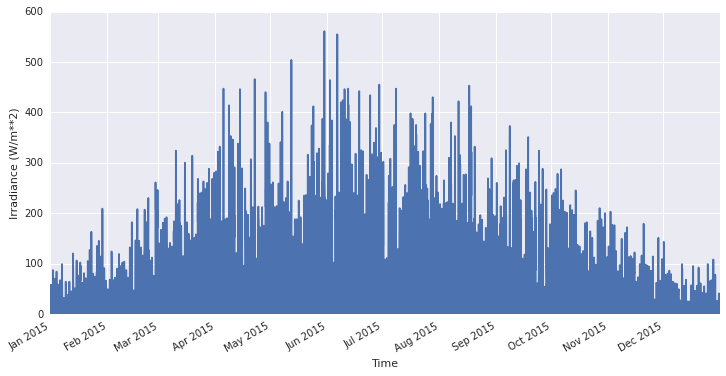

In [4]:
tmy_data.DHI.plot()
plt.ylabel('Irradiance (W/m**2)')

In [5]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz='US/Alaska', 
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

SAND POINT: latitude=55.317, longitude=-160.517, tz=US/Alaska, altitude=7.0


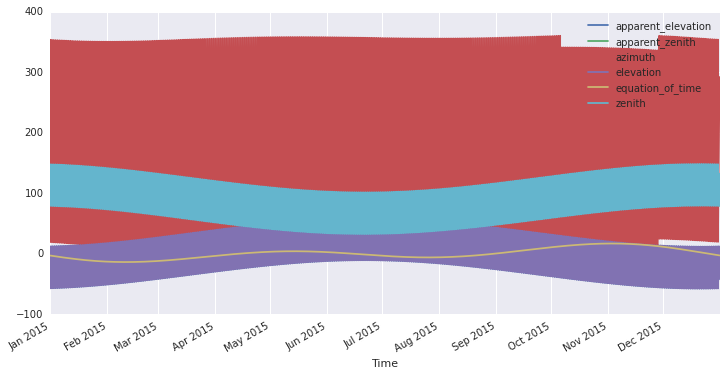

In [6]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point)

solpos.plot()

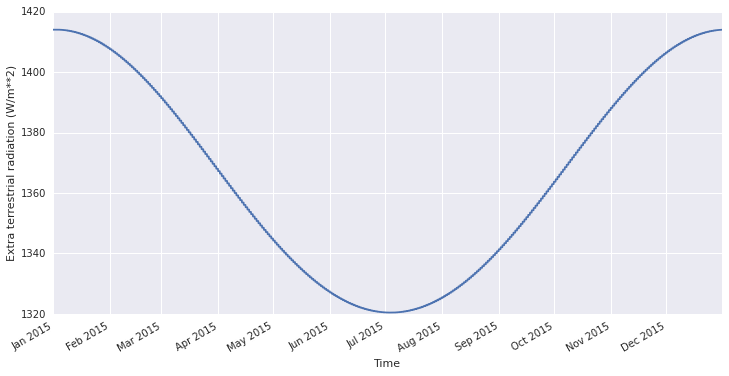

In [7]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.extraradiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)')

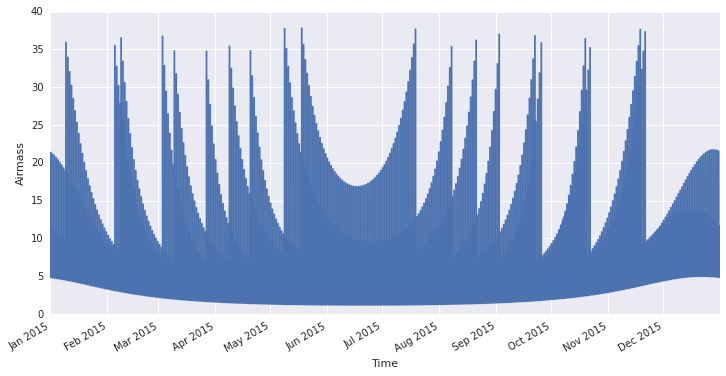

In [8]:
airmass = pvlib.atmosphere.relativeairmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

## Diffuse irradiance models

Make an empty pandas DataFrame for the results.

In [9]:
diffuse_irrad = pd.DataFrame(index=tmy_data.index)

In [10]:
models = ['Perez', 'Hay-Davies', 'Isotropic', 'King', 'Klucher', 'Reindl']

### Perez

In [11]:
diffuse_irrad['Perez'] = pvlib.irradiance.perez(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth,
                               airmass=airmass)

### HayDavies

In [12]:
diffuse_irrad['Hay-Davies'] = pvlib.irradiance.haydavies(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth)

### Isotropic

In [13]:
diffuse_irrad['Isotropic'] = pvlib.irradiance.isotropic(surface_tilt,
                               dhi=tmy_data.DHI)

### King Diffuse model

In [14]:
diffuse_irrad['King'] = pvlib.irradiance.king(surface_tilt,
                               dhi=tmy_data.DHI,
                               ghi=tmy_data.GHI,
                               solar_zenith=solpos.apparent_zenith)

### Klucher Model

In [15]:
diffuse_irrad['Klucher'] = pvlib.irradiance.klucher(surface_tilt, surface_azimuth,
                                                    dhi=tmy_data.DHI,
                                                    ghi=tmy_data.GHI,
                                                    solar_zenith=solpos.apparent_zenith,
                                                    solar_azimuth=solpos.azimuth)

### Reindl

In [16]:
diffuse_irrad['Reindl'] = pvlib.irradiance.reindl(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               ghi=tmy_data.GHI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth)

Calculate yearly, monthly, daily sums.

In [17]:
yearly = diffuse_irrad.resample('A', how='sum').dropna().squeeze() / 1000.0  # kWh
monthly = diffuse_irrad.resample('M', how='sum', kind='period') / 1000.0
daily = diffuse_irrad.resample('D', how='sum') / 1000.0

## Plot Results

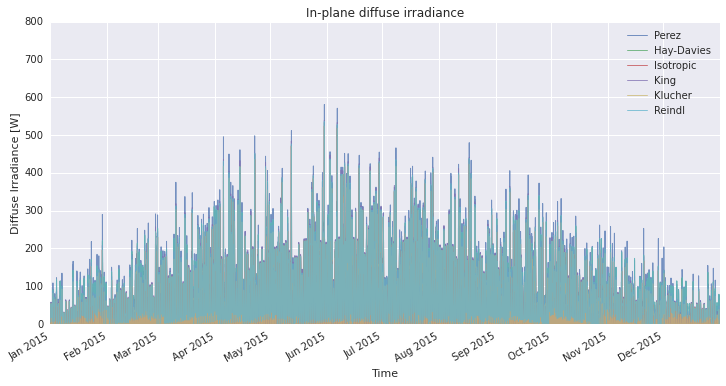

In [18]:
ax = diffuse_irrad.plot(title='In-plane diffuse irradiance', alpha=.75, lw=1)
ax.set_ylim(0, 800)
ylabel = ax.set_ylabel('Diffuse Irradiance [W]')
plt.legend()

In [19]:
diffuse_irrad.describe()

,Perez,Hay-Davies,Isotropic,King,Klucher,Reindl
count,4455.000000,8760.000000,8760.000000,8760.000000,8760.000000,4578.000000
mean,108.930894,52.426696,49.094681,53.067042,49.094681,100.714794
std,83.016708,75.456200,72.134083,76.340191,72.134083,78.428595
min,0.933013,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43.981330,0.000000,0.000000,0.000000,0.000000,39.032486
50%,93.785730,3.732051,3.732051,4.009573,3.732051,87.264803
75%,154.708983,91.277823,81.172105,91.749845,81.172105,145.528344
max,580.711022,533.105626,523.420126,538.809780,523.420126,535.973778


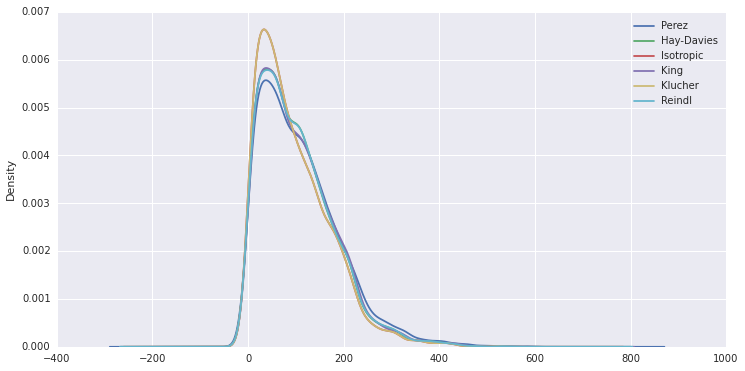

In [20]:
diffuse_irrad.dropna().plot(kind='density')

Daily

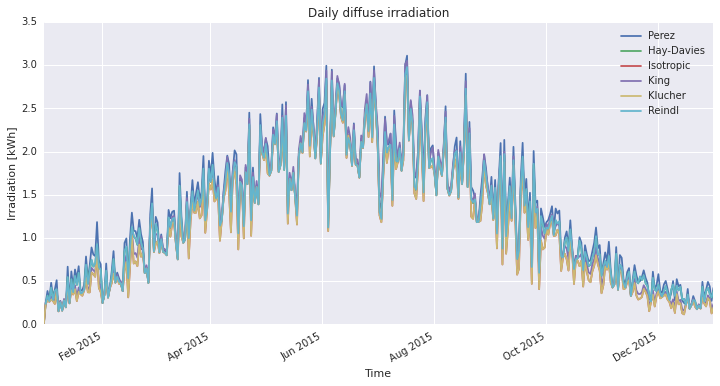

In [21]:
ax_daily = daily.tz_convert('UTC').plot(title='Daily diffuse irradiation')
ylabel = ax_daily.set_ylabel('Irradiation [kWh]')

Monthly

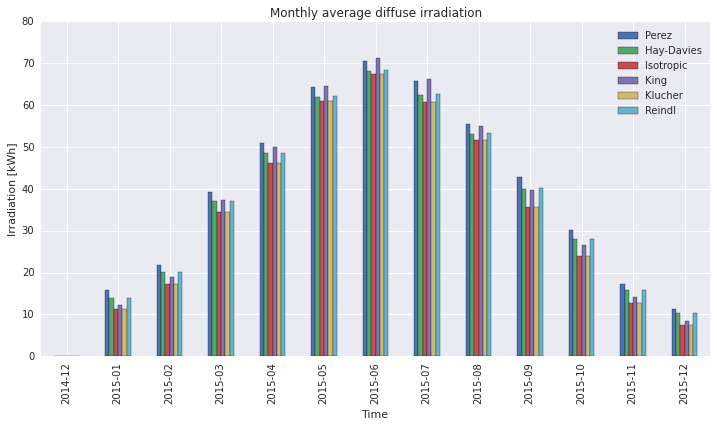

In [22]:
ax_monthly = monthly.plot(title='Monthly average diffuse irradiation', kind='bar')
ylabel = ax_monthly.set_ylabel('Irradiation [kWh]')

Yearly

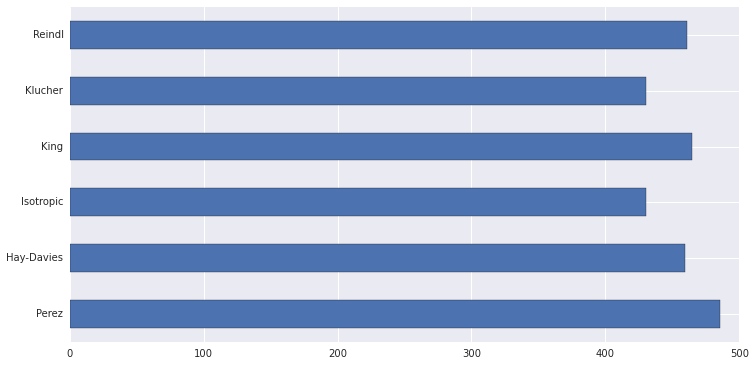

In [23]:
yearly.plot(kind='barh')

Compute the mean deviation from measured for each model and display as a function of the model

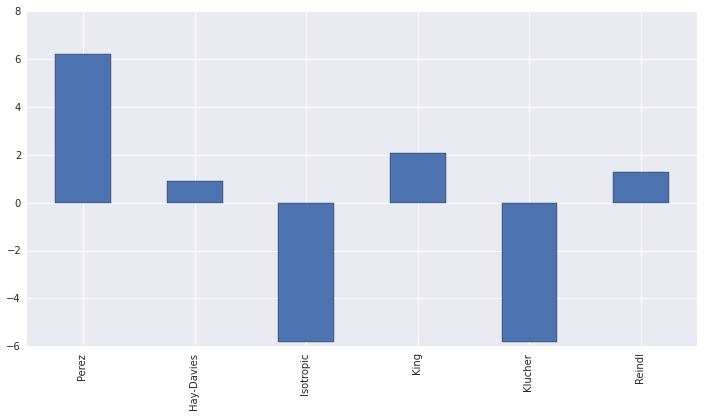

In [24]:
mean_yearly = yearly.mean()
yearly_mean_deviation = (yearly - mean_yearly) / yearly * 100.0
yearly_mean_deviation.plot(kind='bar')